https://academic.oup.com/jrsssa/article/187/2/513/7512935?utm_source=chatgpt.com&login=false

Önceden çalıştırdığım kodda
minute-level spline + ordinal probit + PyMC + NUTS

yapıyorduk ve bunu yaparken her dakikanın aggregated toplamını alıyorduk. Bundan dolayı kod çalışması aşırı uzun sürüyordu ve bunu bu yüzden iptal ettim.

In [1]:
import os
os.environ["PYTENSOR_LINKER"] = "py"
os.environ["PYTENSOR_CXX"] = ""


In [2]:
import pytensor
print("CXX:", pytensor.config.cxx)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


CXX: 


In [5]:
import pytensor.tensor as pt
import multiprocessing
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

Train-Test Split + Bayesian Multinomial Logistic Regression

Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2667 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



----------------------
Test Accuracy: 0.48936170212765956
----------------------



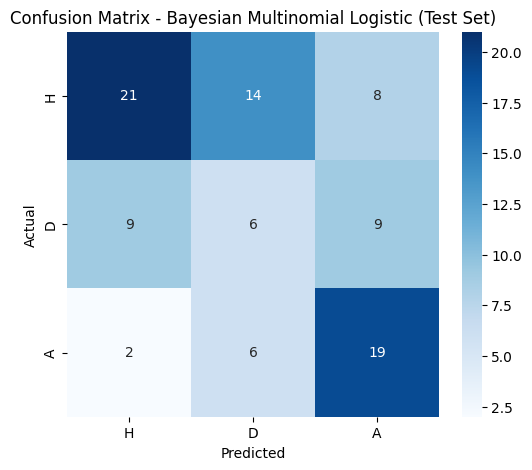

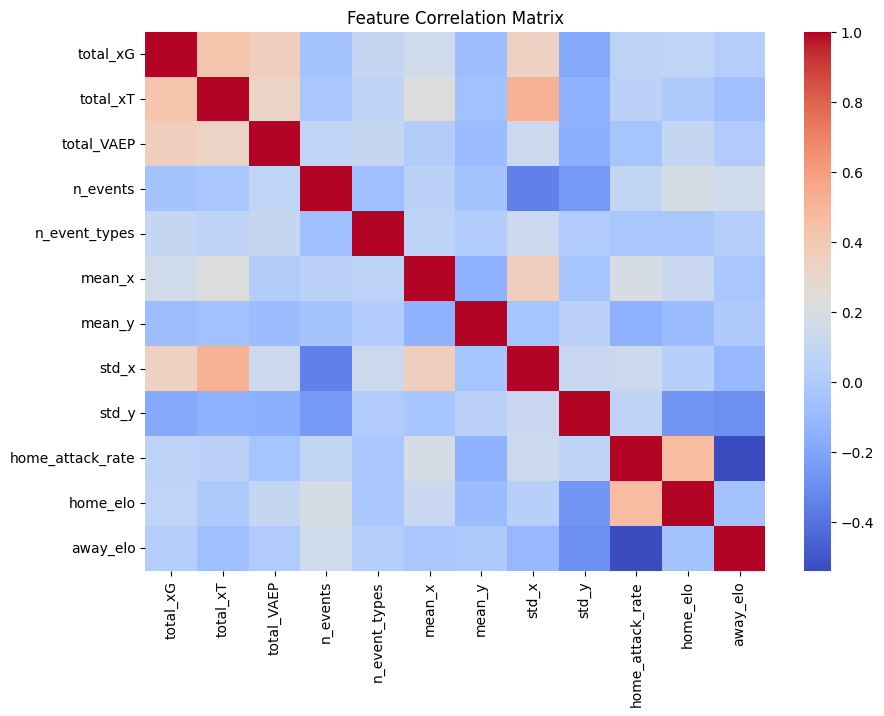

In [ ]:
# ----------------------------------------------------
# 1) Load data
# ----------------------------------------------------

cwd = os.getcwd()
csv_path = os.path.join(cwd, "data", "full_df.csv")
df = pd.read_csv(csv_path)

df["timestamp"] = pd.to_timedelta(df["timestamp"])
df["end_timestamp"] = pd.to_timedelta(df["end_timestamp"])

# ----------------------------------------------------
# 2) Only first 30 minutes, period 1
# ----------------------------------------------------
df_30 = df[
    (df["period_id"] == 1) &
    (df["timestamp"] < pd.Timedelta(minutes=30))
].copy()

# ----------------------------------------------------
# 3) Aggregate features
# ----------------------------------------------------
agg_cumsum = df_30.groupby("matchId").agg(
    total_xG=("xG", "sum"),
    total_xT=("xT_value", "sum"),
    total_VAEP=("VAEP", "sum"),
)

agg_counts = df_30.groupby("matchId").agg(
    n_events=("event_id", "count"),
    n_event_types=("event_type", "nunique"),
)

agg_coords = df_30.groupby("matchId").agg(
    mean_x=("coordinates_x_scaled", "mean"),
    mean_y=("coordinates_y_scaled", "mean"),
    std_x=("coordinates_x_scaled", "std"),
    std_y=("coordinates_y_scaled", "std"),
)

agg_home = df_30.groupby("matchId").agg(
    home_attack_rate=("is_home", "mean")
)

features = (
    agg_cumsum
    .join(agg_counts)
    .join(agg_coords)
    .join(agg_home)
)

elos = df.groupby("matchId").agg(
    home_elo=("home_elo", "first"),
    away_elo=("away_elo", "first"),
    match_result=("match_result", "first")
)

dataset = features.join(elos)

result_map = {"H": 0, "D": 1, "A": 2}
dataset["y"] = dataset["match_result"].map(result_map)

# ----------------------------------------------------
# 4) Train-test split
# ----------------------------------------------------
X = dataset.drop(columns=["match_result", "y"]).values
y = dataset["y"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_features = X_train.shape[1]
n_classes = len(np.unique(y))

# ----------------------------------------------------
# 5) Bayesian Model
# ----------------------------------------------------
with pm.Model() as model:

    beta = pm.Normal("beta", mu=0, sigma=1, shape=(n_features, n_classes))

    logits = pm.math.dot(X_train, beta)

    y_obs = pm.Categorical(
        "y_obs",
        logit_p=logits,
        observed=y_train
    )

    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        target_accept=0.9,
        init="adapt_diag"
    )

# ----------------------------------------------------
# 6) Posterior Predictive on TEST SET
# ----------------------------------------------------
posterior_beta = trace.posterior["beta"].stack(sample=("chain", "draw")).values
# shape: (n_features, n_classes, n_samples)

# logits_test: (n_test, n_classes, n_samples)
logits_test = np.einsum("ij,jks->iks", X_test, posterior_beta)

probs_test = np.exp(logits_test) / np.exp(logits_test).sum(axis=1, keepdims=True)

avg_probs_test = probs_test.mean(axis=2)

pred_classes = np.argmax(avg_probs_test, axis=1)

acc = accuracy_score(y_test, pred_classes)
print("\n----------------------")
print("Test Accuracy:", acc)
print("----------------------\n")

# ----------------------------------------------------
# 7) Confusion Matrix
# ----------------------------------------------------
cm = confusion_matrix(y_test, pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["H","D","A"],
            yticklabels=["H","D","A"])
plt.title("Confusion Matrix - Bayesian Multinomial Logistic (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ----------------------------------------------------
# 8) Feature Correlation Matrix
# ----------------------------------------------------
plt.figure(figsize=(10,7))
sns.heatmap(
    pd.DataFrame(X, columns=dataset.drop(columns=["match_result","y"]).columns).corr(),
    annot=False, cmap="coolwarm"
)
plt.title("Feature Correlation Matrix")
plt.show()


Öncelikle ilk 30 dakikaya bakmak istediğim için sadece ilk periyot ve ilk 30 dakikadaki olayları alıyorum.
Sonra xG, xT ve VAEP değerlerinin ölçülerini maç bazı topluyorum.
Her maç için kaç olay olduğunu ve kaç farklı olay türü olduğunu hesaplıyorum.
Maçtaki top hareketlerinin ortalama ve standart sapma olarak nasıl olduğunu inceliyorum.
Her takım için ayrı çıkarmak yerine toplam olayların ne kadarının ev sahibi tarafından yapıldığını ölçüyorum.
Bunları tek bir özellik matrisi haline getirdikten sonra ev sahibi ve deplasman elo skorlarını ve maç sonuçlarını ekleyip sonuçları kategorik sayıya çeviriyorum.
Özellikleri x ve hedefi y alıp veriyi 75 train 25 test ayırıyorum.
Beta ağırlığını Normal(0,1), logits = X_train @ beta, Gözlemler Categorical dağılım ve MCMC ile posterior trace'leri alıyoruz
- Beta burada her özelliğin her sınıfa olan etkisidir ve prior olan beta'nın genellikle küçük değerler olduğunu varsayıyoruz. Yani önceden neye inanıyoruz sorusuna cevap vermemizi sağlıyor.
- logits her sınıfın doğrusal skoru, örnek ve özellikler matrisini beta ile çarpıyoruz ve olasılık skoru çıkıyor.
- posterios beta parametrelerin olası dağılımını gösterdiği için MCMC ile bu dağılımdan örnekler alıyoruz. Çünkü analitik olarak posterior'u çözmek imkansız. Multinomial ve normal prior'da kapalı form yok ve örnekleme ile yaklaşık çözüm buluyoruz. Bunun sayesinde belirsizlik ile beta dağılımını buluruz.
- Her posterior beta örneği ile olasılık tahminleri oluşturuyoruz. Sonra tüm posterior örneklerin ortalamasını alıyoruz. Bu tahminin sadece tek bir beta değerine bağlı olmadan posterior ortalama olasılık üzerinden yapılmasını sağlıyor. Yani daha güvenilir ve belirsizliği kapsayan tahmin elde ediyoruz. 
Test seti tahminleri için Posterior'dan beta örneklerini alıyorum Test verisi ile logit ve olasılık hesaplıyorum. Sonra sınıf tahmini yapıp doğruluğu hesaplıyorum.
En son confusion matrix ve özellikler arası korelasyon getirip bitiriyorum.

Ama bu kodu kullanmamamızda birkaç neden var:
- Şu anki modelimiz içinde elo'lar zaten var ve tek seferde regresyon içine giriyor. ELO bir prior eventler posterior olması gerekirken böyle bir yapı yok. Bu model bu yüzden tek katmanlı öğrenim yapıyor. Bunu bayesian updating'e çevirmem gerekiyordu. İlk olarak elo farkına göre baseline hesabı oluşturup prior oluştururuz. Sonrasında in match bayesian modelimizi bu prior ile kullanırız. Bu şekilde elo ile hazırlanan olasılıklara göre maç eventleri nasıl değişiyor onu görürüz.
- Alttaki kodun ne yaptığını ve üsttekiyle farklarının ne olduğunu eklerim.

C:\Users\Megad\AppData\Local\Temp\ipykernel_34224\3000817833.py:248: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = pd.concat(frames, axis=1).fillna(0.0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, team_sigma, team_eff_raw, big6_sigma, big6_eff_raw, log_elo_scale, cutpoints]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18464 seconds.



Test Accuracy: 0.5851
Confusion matrix:
 [[33  3  7]
 [13  3  8]
 [ 5  3 19]]
Saved per-match probs to match_level_test_probs.csv


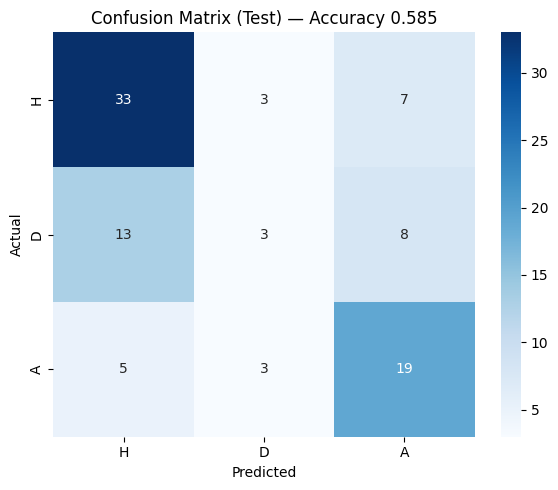

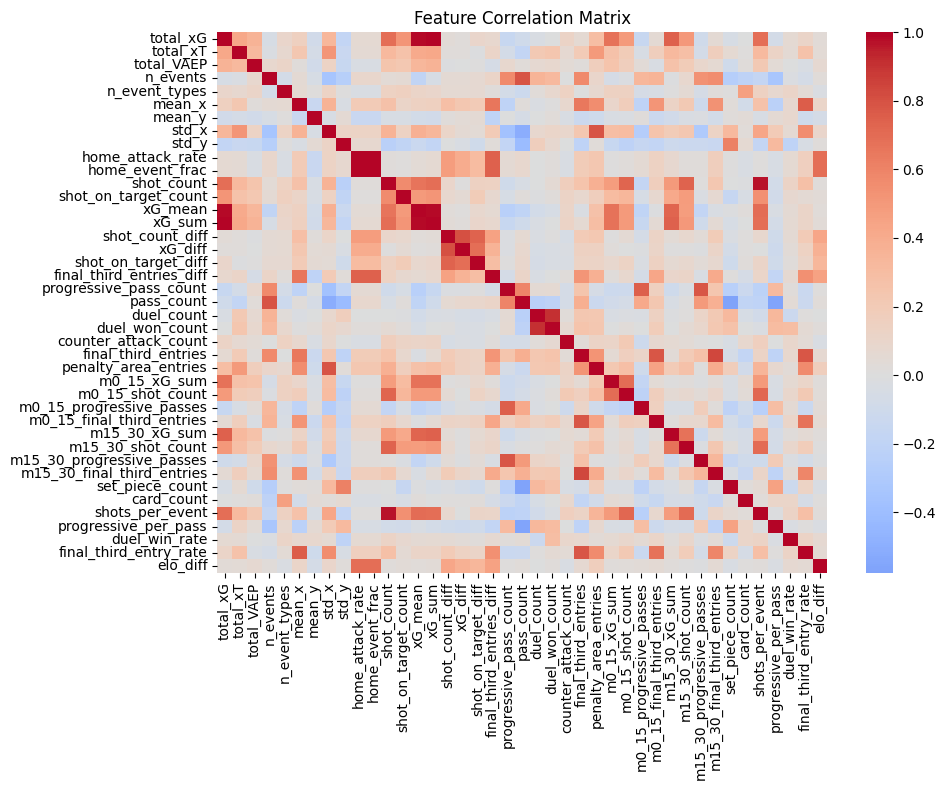


Example first 30 test matches with predicted probs:
2500036: true=0.0 pred=2.0 probs=[np.float64(0.156), np.float64(0.292), np.float64(0.552)]
2499734: true=1.0 pred=0.0 probs=[np.float64(0.811), np.float64(0.143), np.float64(0.046)]
2499769: true=0.0 pred=0.0 probs=[np.float64(0.674), np.float64(0.236), np.float64(0.09)]
2499917: true=0.0 pred=2.0 probs=[np.float64(0.228), np.float64(0.32), np.float64(0.451)]
2499918: true=1.0 pred=0.0 probs=[np.float64(0.436), np.float64(0.331), np.float64(0.233)]
2499753: true=2.0 pred=2.0 probs=[np.float64(0.216), np.float64(0.346), np.float64(0.438)]
2499947: true=1.0 pred=1.0 probs=[np.float64(0.342), np.float64(0.36), np.float64(0.298)]
2499877: true=0.0 pred=0.0 probs=[np.float64(0.907), np.float64(0.073), np.float64(0.02)]
2499878: true=0.0 pred=2.0 probs=[np.float64(0.039), np.float64(0.129), np.float64(0.832)]
2499937: true=2.0 pred=2.0 probs=[np.float64(0.049), np.float64(0.147), np.float64(0.804)]
2499721: true=2.0 pred=0.0 probs=[np.floa

In [10]:
# ---------------------------
# Helpers
# ---------------------------
def softmax_stable(a, axis=1):
    a_max = np.max(a, axis=axis, keepdims=True)
    e = np.exp(a - a_max)
    return e / e.sum(axis=axis, keepdims=True)

# ---------------------------
# Config
# ---------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_DRAWS = 1000
N_TUNE = 1000
CHAINS = 2
CORES = min(4, multiprocessing.cpu_count())

# ---------------------------
# 1) Load data
# ---------------------------
cwd = os.getcwd()
csv_path = os.path.join(cwd, "data", "full_df.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found: {csv_path}")

df = pd.read_csv(csv_path)
df["xG"] = pd.to_numeric(df["xG"], errors="coerce").fillna(0.0)
df["timestamp"] = pd.to_timedelta(df["timestamp"])
df["end_timestamp"] = pd.to_timedelta(df["end_timestamp"])

# ---------------------------
# 2) First 30 minutes, period 1
# ---------------------------
df_30 = df[(df["period_id"] == 1) & (df["timestamp"] < pd.Timedelta(minutes=30))].copy()

# ---------------------------
# New: richer feature engineering (replace previous aggregation block)
# ---------------------------

def aggregate_match_features(df_30,
                             progressive_dx_threshold=10.0,   # in same units as coordinates_x_scaled (likely 0-100)
                             final_third_x=66.7,
                             penalty_area_x=83.3):
    """
    Aggregates a rich set of match-level features from event-level df_30.
    """
    # make a safe copy
    df = df_30.copy()

    # Ensure expected columns exist; create safe defaults where appropriate
    expected_numeric = [
        "coordinates_x_scaled","coordinates_y_scaled",
        "end_coordinates_x_scaled","end_coordinates_y_scaled",
        "xG","xT_value","VAEP"
    ]
    for col in expected_numeric:
        if col not in df.columns:
            df[col] = 0.0
    # coerce to numeric safely
    df[expected_numeric] = df[expected_numeric].apply(lambda s: pd.to_numeric(s, errors="coerce").fillna(0.0))

    # Basic cumulative metrics
    agg_cumsum = df.groupby("matchId").agg(
        total_xG=("xG", "sum"),
        total_xT=("xT_value", "sum"),
        total_VAEP=("VAEP", "sum"),
    )

    # Counts & diversity
    # ensure event_id/event_type exist
    if "event_id" not in df.columns:
        df["event_id"] = np.arange(len(df))
    if "event_type" not in df.columns:
        df["event_type"] = ""
    agg_counts = df.groupby("matchId").agg(
        n_events=("event_id", "count"),
        n_event_types=("event_type", "nunique"),
    )

    # Coordinates summary
    agg_coords = df.groupby("matchId").agg(
        mean_x=("coordinates_x_scaled", "mean"),
        mean_y=("coordinates_y_scaled", "mean"),
        std_x=("coordinates_x_scaled", "std"),
        std_y=("coordinates_y_scaled", "std"),
    )

    # Home attack rate proxy
    if "is_home" not in df.columns:
        df["is_home"] = 0
    agg_home = df.groupby("matchId").agg(
        home_attack_rate=("is_home", "mean")
    )

    # Possession proxy
    possession = df.groupby("matchId").agg(
        home_event_frac=("is_home", "mean")
    )

    # -----------------------
    # Shots & shooting metrics (robust conversions)
    # -----------------------
    # Safely coerce shot_action_id and xG to numeric
    if "shot_action_id" in df.columns:
        shot_action_series = pd.to_numeric(df["shot_action_id"], errors="coerce").fillna(0.0)
    else:
        shot_action_series = pd.Series(0.0, index=df.index)

    xg_series = pd.to_numeric(df["xG"], errors="coerce").fillna(0.0)

    # define is_shot heuristic
    df["is_shot"] = ((shot_action_series.astype(float) != 0) | (xg_series.astype(float) > 0)).astype(int)

    # shot on target proxy: use result column if exists
    if "result" in df.columns:
        res_upper = df["result"].astype(str).str.upper()
        on_target_set = set(["GOAL","ON_TARGET","SAVED","SAVED_TO_CORNER","SAVED_OFF_TARGET"])
        df["shot_on_target"] = ((df["is_shot"] == 1) & (res_upper.isin(on_target_set))).astype(int)
    else:
        df["shot_on_target"] = 0

    shots = df.groupby("matchId").agg(
        shot_count=("is_shot", "sum"),
        shot_on_target_count=("shot_on_target", "sum"),
        xG_mean=("xG", "mean"),
        xG_sum=("xG", "sum"),
    )

    # -----------------------
    # Shot difference & xG diff (home - away)
    # -----------------------
    home_df = df[df["is_home"] == 1]
    away_df = df[df["is_home"] == 0]

    home_shots = home_df.groupby("matchId").agg(
        home_shot_count=("is_shot", "sum"),
        home_xG_sum=("xG", "sum"),
        home_shot_on_target=("shot_on_target", "sum"),
        home_att_entries=("coordinates_x_scaled", lambda s: (s > final_third_x).sum())
    )
    away_shots = away_df.groupby("matchId").agg(
        away_shot_count=("is_shot", "sum"),
        away_xG_sum=("xG", "sum"),
        away_shot_on_target=("shot_on_target", "sum"),
        away_att_entries=("coordinates_x_scaled", lambda s: (s < (100 - final_third_x)).sum())
    )

    shot_diff = pd.concat([home_shots, away_shots], axis=1).fillna(0.0)
    shot_diff["shot_count_diff"] = shot_diff["home_shot_count"] - shot_diff["away_shot_count"]
    shot_diff["xG_diff"] = shot_diff["home_xG_sum"] - shot_diff["away_xG_sum"]
    shot_diff["shot_on_target_diff"] = shot_diff["home_shot_on_target"] - shot_diff["away_shot_on_target"]
    shot_diff["final_third_entries_diff"] = shot_diff["home_att_entries"] - shot_diff["away_att_entries"]

    # -----------------------
    # Progressive passes (heuristic)
    # -----------------------
    is_pass = df["event_type"].astype(str).str.upper().str.contains("PASS", na=False)
    # safe numeric for coordinates
    start_x = pd.to_numeric(df["coordinates_x_scaled"], errors="coerce").fillna(0.0)
    end_x = pd.to_numeric(df.get("end_coordinates_x_scaled", df["coordinates_x_scaled"]), errors="coerce").fillna(0.0)
    df["pass_dx"] = end_x - start_x
    df["is_progressive_pass"] = ((is_pass) & (df["pass_dx"].astype(float) > progressive_dx_threshold)).astype(int)

    progressive = df.groupby("matchId").agg(
        progressive_pass_count=("is_progressive_pass", "sum"),
        pass_count=("event_type", lambda s: s.str.upper().str.contains("PASS").sum())
    )

    # -----------------------
    # Duels / aerials
    # -----------------------
    is_duel = df["event_type"].astype(str).str.upper().str.contains("DUEL", na=False)
    # coerce success flags to string and test common truthy values
    success_str = df.get("success", pd.Series("")).astype(str).str.upper()
    success_ok = success_str.isin(["TRUE","1","YES","WON","SUCCESS"])
    df["duel_won"] = ((is_duel) & (success_ok)).astype(int)
    duels = df.groupby("matchId").agg(
        duel_count=("event_type", lambda s: s.astype(str).str.upper().str.contains("DUEL").sum()),
        duel_won_count=("duel_won", "sum")
    )

    # -----------------------
    # Counterattacks
    # -----------------------
    if "is_counter_attack" in df.columns:
        ca = df.groupby("matchId").agg(counter_attack_count=("is_counter_attack", "sum"))
    else:
        ca = pd.DataFrame(index=df["matchId"].unique()); ca.index.name = "matchId"

    # -----------------------
    # Final-third & penalty-area entries
    # -----------------------
    df["final_third_entry"] = (((start_x > final_third_x) | (end_x > final_third_x))).astype(int)
    df["penalty_area_entry"] = (((start_x > penalty_area_x) | (end_x > penalty_area_x))).astype(int)

    spatial = df.groupby("matchId").agg(
        final_third_entries=("final_third_entry", "sum"),
        penalty_area_entries=("penalty_area_entry", "sum")
    )

    # -----------------------
    # Time splits 0-15 and 15-30 minutes
    # -----------------------
    df = df.copy()
    if np.issubdtype(df["timestamp"].dtype, np.timedelta64):
        df["t_s"] = df["timestamp"].dt.total_seconds()
    else:
        df["t_s"] = pd.to_numeric(df["timestamp"], errors="coerce").fillna(0.0)

    seg_0_15 = df[df["t_s"] < 15 * 60]
    seg_15_30 = df[(df["t_s"] >= 15 * 60) & (df["t_s"] < 30 * 60)]

    def seg_agg(seg, prefix):
        g = seg.groupby("matchId").agg(
            **{f"{prefix}_xG_sum": ("xG", "sum"),
               f"{prefix}_shot_count": ("is_shot", "sum"),
               f"{prefix}_progressive_passes": ("is_progressive_pass", "sum"),
               f"{prefix}_final_third_entries": ("final_third_entry", "sum")}
        )
        return g

    seg0 = seg_agg(seg_0_15, "m0_15")
    seg1 = seg_agg(seg_15_30, "m15_30")

    # -----------------------
    # Set pieces & cards (coarse)
    # -----------------------
    if "set_piece_type" in df.columns:
        setpieces = df.groupby("matchId").agg(set_piece_count=("set_piece_type", lambda s: s.notna().sum()))
    else:
        setpieces = pd.DataFrame(index=df["matchId"].unique()); setpieces.index.name = "matchId"

    if "card_type" in df.columns:
        cards = df.groupby("matchId").agg(card_count=("card_type", lambda s: s.notna().sum()))
    else:
        cards = pd.DataFrame(index=df["matchId"].unique()); cards.index.name = "matchId"

    # -----------------------
    # Combine everything
    # -----------------------
    frames = [
        agg_cumsum, agg_counts, agg_coords, agg_home, possession,
        shots, shot_diff[["shot_count_diff","xG_diff","shot_on_target_diff","final_third_entries_diff"]],
        progressive, duels, ca, spatial, seg0, seg1, setpieces, cards
    ]

    features = pd.concat(frames, axis=1).fillna(0.0)

    # engineered ratios / normalized features
    features["shots_per_event"] = features["shot_count"] / (features["n_events"].replace(0, np.nan))
    features["progressive_per_pass"] = features["progressive_pass_count"] / (features["pass_count"].replace(0, np.nan))
    features["duel_win_rate"] = features["duel_won_count"] / (features["duel_count"].replace(0, np.nan))
    features["final_third_entry_rate"] = features["final_third_entries"] / (features["n_events"].replace(0, np.nan))

    # clean up numeric issues
    features.replace([np.inf, -np.inf], 0.0, inplace=True)
    features.fillna(0.0, inplace=True)

    return features

# Replace old aggregation with new call
features = aggregate_match_features(df_30)

# ---------------------------
# 4) Elo and labels (unchanged)
# ---------------------------
elos = df.groupby("matchId").agg(
    home_elo=("home_elo", "first"),
    away_elo=("away_elo", "first"),
    match_result=("match_result", "first"),
    home_team=("home_team", "first"),
    away_team=("away_team", "first")
)
dataset = features.join(elos)
dataset = dataset[dataset["match_result"].notna()]
result_map = {"H": 0, "D": 1, "A": 2}
dataset["y"] = dataset["match_result"].map(result_map)
y = dataset["y"].values
n_classes = len(np.unique(y))

# ---------------------------
# Rebuild X_df and X_aug (unchanged except features now richer)
# ---------------------------
drop_cols = ["match_result", "y", "home_elo", "away_elo", "home_team", "away_team"]
X_df = dataset.drop(columns=drop_cols)
match_ids = dataset.index.astype(str).to_numpy()
X_df = X_df.fillna(0.0)

# Add Elo difference as feature (same as before)
elo_diff = dataset["home_elo"] - dataset["away_elo"]
X_aug = np.hstack([X_df.values, elo_diff.values.reshape(-1,1)])
n_features_aug = X_aug.shape[1]


# ---------------------------
# 5) Feature matrix and augmentation
# ---------------------------
drop_cols = ["match_result", "y", "home_elo", "away_elo", "home_team", "away_team"]
X_df = dataset.drop(columns=drop_cols)
match_ids = dataset.index.astype(str).to_numpy()
X_df = X_df.fillna(0.0)

# Add Elo difference as feature
elo_diff = dataset["home_elo"] - dataset["away_elo"]
X_aug = np.hstack([X_df.values, elo_diff.values.reshape(-1,1)])
n_features_aug = X_aug.shape[1]

# ---------------------------
# 6) Team indices for random effects
# ---------------------------
big6 = ["Arsenal", "Liverpool", "Manchester City", "Manchester United", "Chelsea", "Tottenham Hotspur"]
teams = pd.concat([dataset["home_team"], dataset["away_team"]]).unique()
team_to_idx = {team: i for i, team in enumerate(teams)}
n_teams = len(teams)
home_idx = dataset["home_team"].map(team_to_idx).to_numpy()
away_idx = dataset["away_team"].map(team_to_idx).to_numpy()
is_big6_home = dataset["home_team"].isin(big6).astype(int).to_numpy()

# ---------------------------
# 7) Train-test split
# ---------------------------
X_train, X_test, y_train, y_test, home_idx_train, home_idx_test, \
away_idx_train, away_idx_test, big6_train, big6_test, mid_train, mid_test = train_test_split(
    X_aug, y, home_idx, away_idx, is_big6_home, match_ids,
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------------
# 8) Bayesian Ordered Logistic + Random Effects
# ---------------------------

with pm.Model() as model:
    
    # ---- Data containers ----
    X_data = pm.Data("X_data", X_train)
    home_idx_data = pm.Data("home_idx", home_idx_train)
    away_idx_data = pm.Data("away_idx", away_idx_train)
    big6_data = pm.Data("big6_data", big6_train)
    elo_diff_data = pm.Data("elo_diff", X_train[:, -1])   # last column is elo_diff
    
    # ---- Priors for coefficients ----
    beta = pm.Normal("beta", mu=0, sigma=1.0, shape=n_features_aug)   # coefficient vector (one latent score)
    alpha = pm.Normal("alpha", mu=0, sigma=1.0)                       # intercept
    
    # ---- Random Effects: Teams (NON-CENTERED) ----
    team_sigma = pm.HalfNormal("team_sigma", sigma=0.5)
    team_eff_raw = pm.Normal("team_eff_raw", mu=0, sigma=1.0, shape=n_teams)
    team_eff = pm.Deterministic("team_eff", team_eff_raw * team_sigma)  # non-centered transform
    team_contrib = team_eff[home_idx_data] - team_eff[away_idx_data]
    
    # ---- Big6 Home Advantage (non-centered style) ----
    big6_sigma = pm.HalfNormal("big6_sigma", sigma=0.5)
    big6_eff_raw = pm.Normal("big6_eff_raw", mu=0, sigma=1.0)
    big6_eff = pm.Deterministic("big6_eff", big6_eff_raw * big6_sigma)
    big6_contrib = big6_data * big6_eff
    
    # ---- Elo Scaling (log-scale for positivity, more stable) ----
    log_elo_scale = pm.Normal("log_elo_scale", mu=0.0, sigma=1.0)
    elo_scale = pm.Deterministic("elo_scale", pm.math.exp(log_elo_scale))
    elo_contrib = elo_scale * elo_diff_data
    
    # ---- Linear predictor (single η per observation) ----
    eta = (
        pm.math.dot(X_data, beta)      # (n_obs,)
        + alpha
        + team_contrib
        + big6_contrib
        + elo_contrib
    )
    
    # ---- Ordered Logistic Cutpoints ----
    cutpoints = pm.Normal(
        "cutpoints",
        mu=np.array([-1.0, 1.0]),  # H < D < A
        sigma=1.0,
        transform=pm.distributions.transforms.ordered
    )
    
    # ---- Likelihood ----
    y_obs = pm.OrderedLogistic(
        "y_obs",
        eta=eta,
        cutpoints=cutpoints,
        observed=y_train
    )
    
    # ---- Sampling (more robust defaults) ----
    # NOTE: I increased chains to 4 and target_accept to 0.99 to reduce divergences.
    trace = pm.sample(
        draws=N_DRAWS,
        tune=N_TUNE,
        chains=4,                     # more chains for better convergence diagnostics
        cores=CORES,
        random_seed=RANDOM_STATE,
        target_accept=0.99,           # reduce divergences
        init="jitter+adapt_diag"      # more robust init
    )

# ---------------------------
# 9) Posterior predictives, metrics, confusion matrix (Ordered Logistic + Random Effects)
# ---------------------------
# stack samples from chains into a single sample axis
post = trace.posterior.stack(sample=("chain","draw"))

# extract arrays with expected shapes:
# posterior_beta: (n_features, S)
posterior_beta = post["beta"].values                 # (n_features, S)
# posterior_alpha: (S,)
posterior_alpha = post["alpha"].values               # (S,)
# posterior_team_eff: (n_teams, S)  (we computed team_eff as deterministic)
posterior_team_eff = post["team_eff"].values         # (n_teams, S)
# posterior_big6_eff: (S,)
posterior_big6_eff = post["big6_eff"].values         # (S,)
# posterior_elo_scale: (S,)
posterior_elo_scale = post["elo_scale"].values       # (S,)
# posterior_cutpoints: (n_cutpoints, S)
posterior_cutpoints = post["cutpoints"].values       # (n_cutpoints, S)

S = posterior_beta.shape[1]

# Prepare arrays for test data
n_test = X_test.shape[0]
n_cutpoints = posterior_cutpoints.shape[0]
n_classes = n_cutpoints + 1
probs_test = np.zeros((n_test, n_classes, S))

# make sure home_idx_test, away_idx_test, big6_test are numpy arrays of int/0-1
home_idx_test = np.asarray(home_idx_test, dtype=int)
away_idx_test = np.asarray(away_idx_test, dtype=int)
big6_test = np.asarray(big6_test, dtype=int)

for s in range(S):
    # beta_s: (n_features,)
    beta_s = posterior_beta[:, s]
    # main linear predictor (n_test,)
    eta_main = X_test @ beta_s
    # intercept
    alpha_s = posterior_alpha[s]
    eta = eta_main + alpha_s
    
    # team contribution (n_test,)
    team_eff_s = posterior_team_eff[:, s]  # (n_teams,)
    team_contrib = team_eff_s[home_idx_test] - team_eff_s[away_idx_test]
    eta = eta + team_contrib
    
    # big6 home contribution
    big6_s = posterior_big6_eff[s]
    eta = eta + (big6_test * big6_s)
    
    # elo contribution: last column of X_test is elo_diff
    elo_scale_s = posterior_elo_scale[s]
    elo_diff_test = X_test[:, -1]
    eta = eta + (elo_scale_s * elo_diff_test)
    
    # cutpoints for this sample (sorted)
    cuts = posterior_cutpoints[:, s]  # (n_cutpoints,)
    
    # compute ordered-logit category probabilities
    p_sample = np.zeros((n_test, n_classes))
    # P(y=0) = sigmoid(cut0 - eta)
    p_sample[:, 0] = expit(cuts[0] - eta)
    # middle categories
    for k in range(1, n_classes-1):
        p_sample[:, k] = expit(cuts[k] - eta) - expit(cuts[k-1] - eta)
    # last category
    p_sample[:, n_classes-1] = 1.0 - expit(cuts[-1] - eta)
    
    probs_test[:, :, s] = p_sample

# average across posterior samples
avg_probs_test = probs_test.mean(axis=2)
pred_classes = np.argmax(avg_probs_test, axis=1)

# ---------------------------
# 10) Metrics & diagnostics
# ---------------------------
acc = accuracy_score(y_test, pred_classes)
cm = confusion_matrix(y_test, pred_classes)

print(f"\nTest Accuracy: {acc:.4f}")
print("Confusion matrix:\n", cm)

# per-match probability table
out_df = pd.DataFrame(
    avg_probs_test,
    columns=["p_home","p_draw","p_away"],
    index=mid_test
)
out_df["true_label"] = y_test
out_df["pred_label"] = pred_classes

# save
csv_path = os.path.join(os.getcwd(), "data", "match_level_test_probs.csv")
out_df.to_csv(csv_path, index_label="matchId")
print("Saved per-match probs to match_level_test_probs.csv")

# ---------------------------
# 11) Plots: confusion matrix and feature correlation
# ---------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["H","D","A"], yticklabels=["H","D","A"])
plt.title(f"Confusion Matrix (Test) — Accuracy {acc:.3f}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
feat_names = X_df.columns.tolist() + ["elo_diff"]
corrmat = pd.DataFrame(X_aug, columns=feat_names).corr()
sns.heatmap(corrmat, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# ---------------------------
# 12) Optional: per-match print (first 30)
# ---------------------------
print("\nExample first 30 test matches with predicted probs:")
for mid, row in out_df.head(30).iterrows():
    print(f"{mid}: true={row['true_label']} pred={row['pred_label']} probs={[round(x,3) for x in row[['p_home','p_draw','p_away']].values]}")